# Topología de Datos con Swiss Roll: Análisis de Variedades Estructuradas

## Introducción

En este notebook exploraremos las técnicas de visualización topológica aplicadas a **datasets tabulares estructurados**, específicamente el **Swiss Roll** - una variedad (manifold) 3D clásica utilizada para evaluar métodos de reducción de dimensionalidad.

### ¿Por qué Swiss Roll?
- Es una **variedad 2D embebida en espacio 3D** con estructura conocida
- Tiene una **dimensión intrínseca de 1** (se puede "desenrollar" a una línea)
- Permite evaluar qué tan bien las técnicas preservan la **geometría intrínseca**
- Es un benchmark estándar para métodos de manifold learning

### Técnicas que aplicaremos:
1. **t-SNE** - Preservación de vecindarios locales
2. **UMAP** - Balance entre estructura local y global  
3. **Isomap** - Preservación de distancias geodésicas
4. **PHATE** - Preservación de transiciones suaves

### Métricas específicas para variedades:
- **Trustworthiness**: ¿Los vecinos cercanos en embedding eran cercanos originalmente?
- **Continuity**: ¿Los vecinos cercanos originales siguen siendo cercanos?
- **Stress**: Preservación general de distancias

In [1]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Técnicas de reducción de dimensionalidad
from sklearn.manifold import TSNE, Isomap
from sklearn.datasets import make_swiss_roll, make_s_curve
from sklearn.preprocessing import StandardScaler
import umap
import phate

# Métricas específicas para variedades
from sklearn.manifold import trustworthiness
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
from sklearn.neighbors import NearestNeighbors

# Utilidades
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

print("Librerías importadas correctamente ✓")

Librerías importadas correctamente ✓


## Generación del Dataset Swiss Roll

El Swiss Roll es una variedad 2D embebida en espacio 3D que tiene forma de rollo suizo. Su estructura intrínseca es unidimensional - se puede "desenrollar" completamente a una línea recta.

### Características del Swiss Roll:
- **Dimensión ambiente**: 3D (x, y, z)
- **Dimensión intrínseca**: 1D (posición a lo largo del rollo)
- **Estructura**: Helicoidal con color que indica la posición intrínseca
- **Desafío**: Las distancias euclidianas no reflejan las distancias geodésicas reales

In [2]:
# Generar el Swiss Roll dataset con diferentes niveles de ruido
n_samples = 1000
noise_levels = [0.0, 0.1, 0.2]
swiss_rolls = {}

print("Generando Swiss Roll datasets...")
for noise in noise_levels:
    X, color = make_swiss_roll(n_samples=n_samples, noise=noise, random_state=42)
    swiss_rolls[noise] = {'data': X, 'color': color}
    print(f"✓ Swiss Roll con ruido {noise}: {X.shape}")

# Usar el dataset con ruido mínimo para el análisis principal
X_swiss = swiss_rolls[0.1]['data']
color_swiss = swiss_rolls[0.1]['color']

print(f"\nDataset principal:")
print(f"Forma: {X_swiss.shape}")
print(f"Rango X: [{X_swiss[:, 0].min():.2f}, {X_swiss[:, 0].max():.2f}]")
print(f"Rango Y: [{X_swiss[:, 1].min():.2f}, {X_swiss[:, 1].max():.2f}]")
print(f"Rango Z: [{X_swiss[:, 2].min():.2f}, {X_swiss[:, 2].max():.2f}]")
print(f"Color (posición intrínseca): [{color_swiss.min():.2f}, {color_swiss.max():.2f}]")

# Normalizar para consistencia con otras técnicas
scaler = StandardScaler()
X_swiss_scaled = scaler.fit_transform(X_swiss)

Generando Swiss Roll datasets...
✓ Swiss Roll con ruido 0.0: (1000, 3)
✓ Swiss Roll con ruido 0.1: (1000, 3)
✓ Swiss Roll con ruido 0.2: (1000, 3)

Dataset principal:
Forma: (1000, 3)
Rango X: [-9.70, 12.76]
Rango Y: [-0.04, 21.00]
Rango Z: [-11.20, 14.23]
Color (posición intrínseca): [4.76, 14.13]


## Visualización del Dataset Original

Exploremos la estructura del Swiss Roll en 3D y entendamos por qué es un desafío para las técnicas de reducción de dimensionalidad.

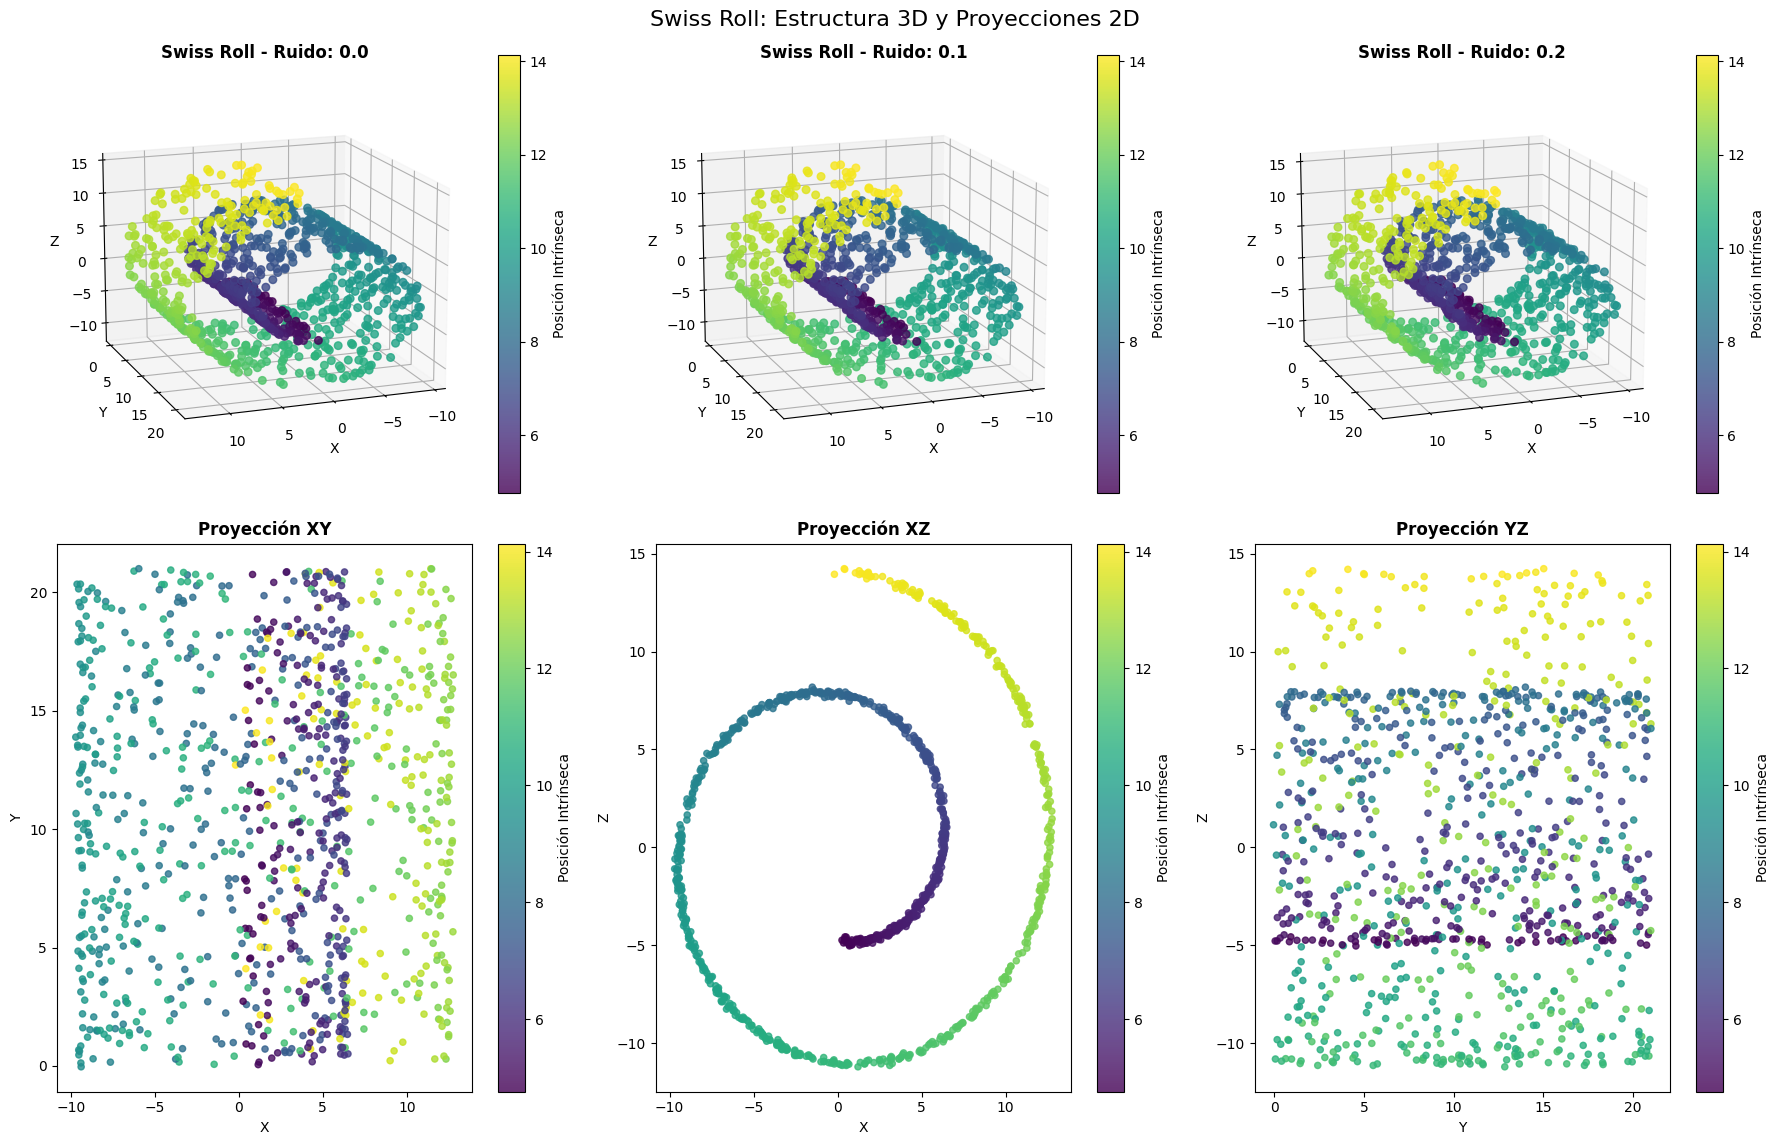

ANÁLISIS DE LA ESTRUCTURA INTRÍNSECA:
El color representa la posición a lo largo del 'desenrollado' del Swiss Roll
Puntos cercanos en color deberían estar cerca en el embedding ideal
El desafío: puntos cercanos en 3D pueden estar lejos intrínsecanemente


In [3]:
# Visualización 3D del Swiss Roll original
fig = plt.figure(figsize=(18, 12))

# Swiss Roll con diferentes niveles de ruido
for i, (noise, data_dict) in enumerate(swiss_rolls.items()):
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    
    X = data_dict['data']
    color = data_dict['color']
    
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], 
                        c=color, cmap='viridis', s=30, alpha=0.8)
    
    ax.set_title(f'Swiss Roll - Ruido: {noise}', fontsize=12, fontweight='bold')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=15, azim=70)
    
    # Añadir colorbar
    plt.colorbar(scatter, ax=ax, shrink=0.8, label='Posición Intrínseca')

# Proyecciones 2D del dataset principal
X = X_swiss
color = color_swiss

# XY projection
ax4 = fig.add_subplot(2, 3, 4)
scatter = ax4.scatter(X[:, 0], X[:, 1], c=color, cmap='viridis', s=20, alpha=0.8)
ax4.set_title('Proyección XY', fontweight='bold')
ax4.set_xlabel('X')
ax4.set_ylabel('Y')
plt.colorbar(scatter, ax=ax4, label='Posición Intrínseca')

# XZ projection
ax5 = fig.add_subplot(2, 3, 5)
scatter = ax5.scatter(X[:, 0], X[:, 2], c=color, cmap='viridis', s=20, alpha=0.8)
ax5.set_title('Proyección XZ', fontweight='bold')
ax5.set_xlabel('X')
ax5.set_ylabel('Z')
plt.colorbar(scatter, ax=ax5, label='Posición Intrínseca')

# YZ projection
ax6 = fig.add_subplot(2, 3, 6)
scatter = ax6.scatter(X[:, 1], X[:, 2], c=color, cmap='viridis', s=20, alpha=0.8)
ax6.set_title('Proyección YZ', fontweight='bold')
ax6.set_xlabel('Y')
ax6.set_ylabel('Z')
plt.colorbar(scatter, ax=ax6, label='Posición Intrínseca')

plt.suptitle('Swiss Roll: Estructura 3D y Proyecciones 2D', fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

# Análisis de la estructura intrínseca
print("ANÁLISIS DE LA ESTRUCTURA INTRÍNSECA:")
print("="*50)
print(f"El color representa la posición a lo largo del 'desenrollado' del Swiss Roll")
print(f"Puntos cercanos en color deberían estar cerca en el embedding ideal")
print(f"El desafío: puntos cercanos en 3D pueden estar lejos intrínsecanemente")

## 1. t-SNE: Preservación de Vecindarios Locales

t-SNE intenta preservar las relaciones de vecindad local. Para Swiss Roll, esto significa que debería agrupar puntos que están cerca en la superficie del rollo, pero puede no preservar la estructura global unidimensional.

In [4]:
# Aplicar t-SNE con diferentes valores de perplexity
perplexities = [5, 20, 50, 100]
tsne_results = {}
tsne_times = {}

print("Aplicando t-SNE con diferentes perplexities...")
for perp in tqdm(perplexities):
    start_time = time.time()
    
    tsne = TSNE(
        n_components=2,
        perplexity=perp,
        learning_rate='auto',
        n_iter=1000,
        random_state=42,
        init='random'
    )
    
    embedding = tsne.fit_transform(X_swiss_scaled)
    
    end_time = time.time()
    tsne_results[perp] = embedding
    tsne_times[perp] = end_time - start_time
    
    print(f"  Perplexity {perp}: {tsne_times[perp]:.2f}s")

print("¡t-SNE completado!")

Aplicando t-SNE con diferentes perplexities...


 25%|██▌       | 1/4 [00:02<00:06,  2.00s/it]

  Perplexity 5: 2.00s


 50%|█████     | 2/4 [00:04<00:04,  2.10s/it]

  Perplexity 20: 2.16s


 75%|███████▌  | 3/4 [00:07<00:02,  2.57s/it]

  Perplexity 50: 3.12s


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]

  Perplexity 100: 3.66s
¡t-SNE completado!


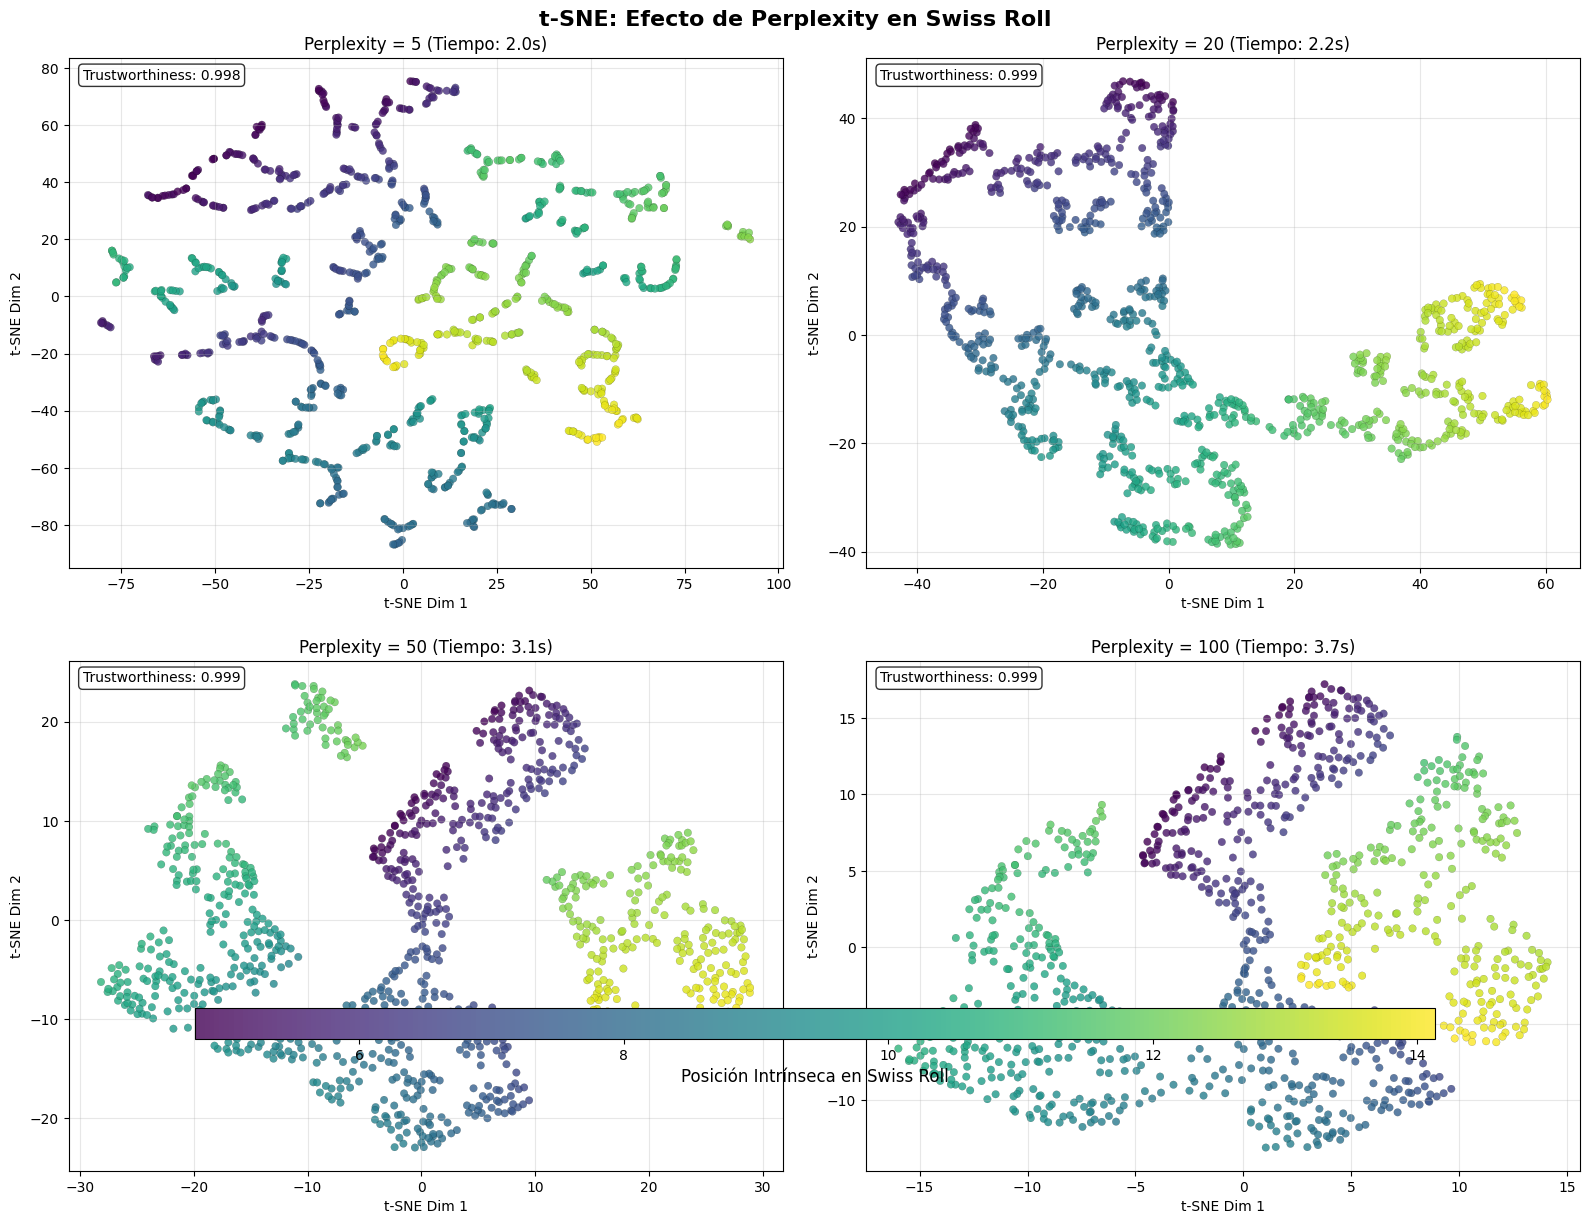


ANÁLISIS DE RESULTADOS t-SNE:
• Perplexity baja (5): Estructura muy fragmentada, muchos clusters
• Perplexity media (20-50): Mejor balance, estructura más continua
• Perplexity alta (100): Estructura más global pero menos detalle local
• El color debería mostrar gradientes continuos en un buen embedding


In [5]:
# Visualizar resultados de t-SNE
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('t-SNE: Efecto de Perplexity en Swiss Roll', fontsize=16, fontweight='bold')

for i, perp in enumerate(perplexities):
    ax = axes[i//2, i%2]
    
    embedding = tsne_results[perp]
    
    scatter = ax.scatter(
        embedding[:, 0], embedding[:, 1],
        c=color_swiss, cmap='viridis', 
        s=30, alpha=0.8, edgecolor='black', linewidth=0.1
    )
    
    ax.set_title(f'Perplexity = {perp} (Tiempo: {tsne_times[perp]:.1f}s)')
    ax.set_xlabel('t-SNE Dim 1')
    ax.set_ylabel('t-SNE Dim 2')
    ax.grid(True, alpha=0.3)
    
    # Calcular trustworthiness
    trust_score = trustworthiness(X_swiss_scaled, embedding, n_neighbors=10)
    ax.text(0.02, 0.98, f'Trustworthiness: {trust_score:.3f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            fontsize=10)

# Colorbar común
cbar = fig.colorbar(scatter, ax=axes, orientation='horizontal', 
                    fraction=0.05, pad=0.1, aspect=40)
cbar.set_label('Posición Intrínseca en Swiss Roll', fontsize=12)

plt.tight_layout()
plt.show()

# Análisis de los resultados
print("\nANÁLISIS DE RESULTADOS t-SNE:")
print("="*40)
print("• Perplexity baja (5): Estructura muy fragmentada, muchos clusters")
print("• Perplexity media (20-50): Mejor balance, estructura más continua") 
print("• Perplexity alta (100): Estructura más global pero menos detalle local")
print("• El color debería mostrar gradientes continuos en un buen embedding")

## 2. UMAP: Balance Local-Global

UMAP está diseñado específicamente para preservar tanto la estructura local como global de las variedades. Para Swiss Roll, debería poder "desenrollar" la estructura manteniendo las relaciones de vecindad.

In [6]:
# Aplicar UMAP con diferentes parámetros
n_neighbors_list = [5, 15, 30, 50]
umap_results = {}
umap_times = {}

print("Aplicando UMAP con diferentes n_neighbors...")
for n_neigh in tqdm(n_neighbors_list):
    start_time = time.time()
    
    umap_model = umap.UMAP(
        n_neighbors=n_neigh,
        min_dist=0.1,
        n_components=2,
        random_state=42,
        metric='euclidean'
    )
    
    embedding = umap_model.fit_transform(X_swiss_scaled)
    
    end_time = time.time()
    umap_results[n_neigh] = embedding
    umap_times[n_neigh] = end_time - start_time
    
    print(f"  n_neighbors {n_neigh}: {umap_times[n_neigh]:.2f}s")

print("¡UMAP completado!")

Aplicando UMAP con diferentes n_neighbors...


 25%|██▌       | 1/4 [00:08<00:24,  8.06s/it]

  n_neighbors 5: 8.06s


 50%|█████     | 2/4 [00:10<00:09,  4.54s/it]

  n_neighbors 15: 2.07s


 75%|███████▌  | 3/4 [00:12<00:03,  3.54s/it]

  n_neighbors 30: 2.35s


100%|██████████| 4/4 [00:15<00:00,  3.80s/it]

  n_neighbors 50: 2.70s
¡UMAP completado!


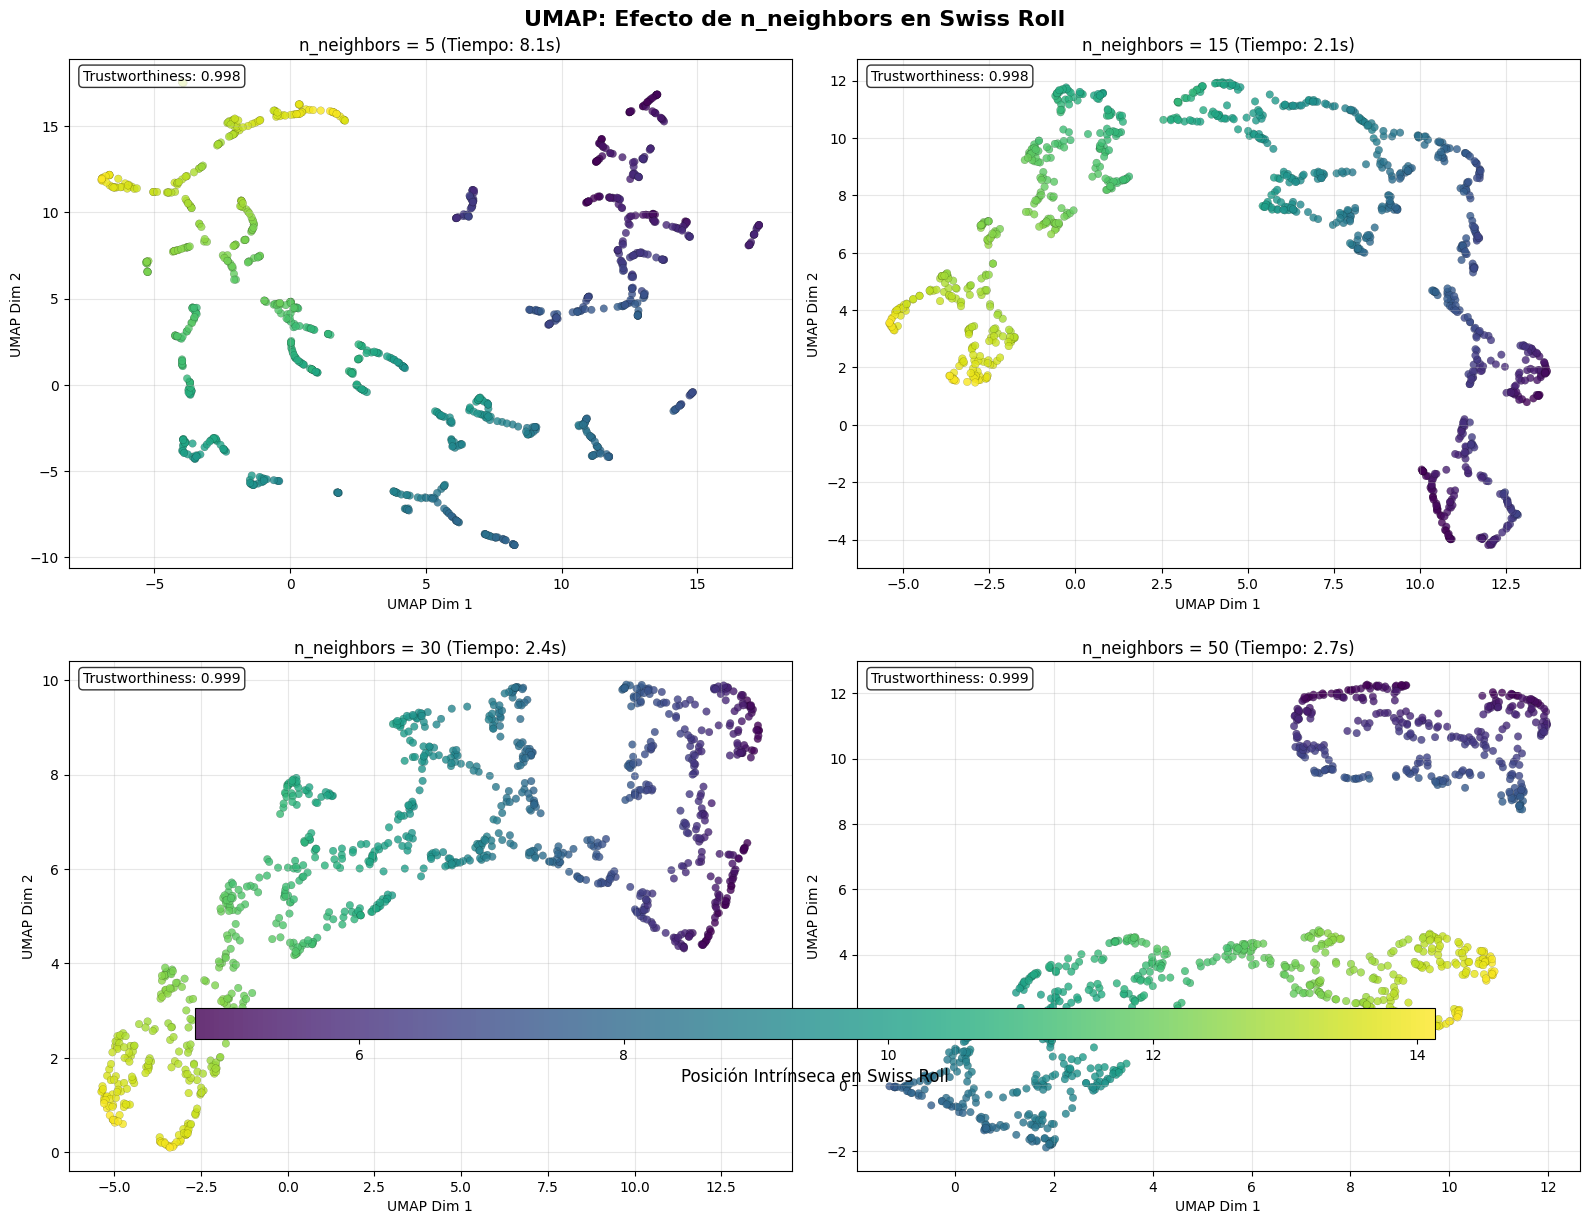


ANÁLISIS DE RESULTADOS UMAP:
• n_neighbors bajo (5): Estructura más local, puede ser fragmentada
• n_neighbors medio (15-30): Buen balance, debería mostrar desenrollado
• n_neighbors alto (50): Más estructura global, menos detalles locales
• UMAP generalmente mejor para preservar topología global que t-SNE


In [7]:
# Visualizar resultados de UMAP
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('UMAP: Efecto de n_neighbors en Swiss Roll', fontsize=16, fontweight='bold')

for i, n_neigh in enumerate(n_neighbors_list):
    ax = axes[i//2, i%2]
    
    embedding = umap_results[n_neigh]
    
    scatter = ax.scatter(
        embedding[:, 0], embedding[:, 1],
        c=color_swiss, cmap='viridis', 
        s=30, alpha=0.8, edgecolor='black', linewidth=0.1
    )
    
    ax.set_title(f'n_neighbors = {n_neigh} (Tiempo: {umap_times[n_neigh]:.1f}s)')
    ax.set_xlabel('UMAP Dim 1')
    ax.set_ylabel('UMAP Dim 2')
    ax.grid(True, alpha=0.3)
    
    # Calcular trustworthiness
    trust_score = trustworthiness(X_swiss_scaled, embedding, n_neighbors=10)
    ax.text(0.02, 0.98, f'Trustworthiness: {trust_score:.3f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            fontsize=10)

# Colorbar común
cbar = fig.colorbar(scatter, ax=axes, orientation='horizontal', 
                    fraction=0.05, pad=0.1, aspect=40)
cbar.set_label('Posición Intrínseca en Swiss Roll', fontsize=12)

plt.tight_layout()
plt.show()

print("\nANÁLISIS DE RESULTADOS UMAP:")
print("="*40)
print("• n_neighbors bajo (5): Estructura más local, puede ser fragmentada")
print("• n_neighbors medio (15-30): Buen balance, debería mostrar desenrollado")
print("• n_neighbors alto (50): Más estructura global, menos detalles locales")
print("• UMAP generalmente mejor para preservar topología global que t-SNE")

## 3. Isomap: Preservación Geodésica

Isomap está específicamente diseñado para preservar distancias geodésicas en variedades. Para Swiss Roll, esto significa que debería poder "desenrollar" perfectamente la estructura, ya que las distancias geodésicas capturan las distancias reales a lo largo de la superficie.

In [8]:
# Aplicar Isomap con diferentes números de vecinos
n_neighbors_iso = [5, 10, 20, 30]
isomap_results = {}
isomap_times = {}

print("Aplicando Isomap con diferentes n_neighbors...")
for n_neigh in tqdm(n_neighbors_iso):
    start_time = time.time()
    
    isomap = Isomap(
        n_neighbors=n_neigh,
        n_components=2,
        eigen_solver='auto',
        path_method='auto'
    )
    
    embedding = isomap.fit_transform(X_swiss_scaled)
    
    end_time = time.time()
    isomap_results[n_neigh] = embedding
    isomap_times[n_neigh] = end_time - start_time
    
    print(f"  n_neighbors {n_neigh}: {isomap_times[n_neigh]:.2f}s")

print("¡Isomap completado!")

Aplicando Isomap con diferentes n_neighbors...


 25%|██▌       | 1/4 [00:00<00:00,  3.89it/s]

  n_neighbors 5: 0.26s


 50%|█████     | 2/4 [00:00<00:00,  2.88it/s]

  n_neighbors 10: 0.41s


 75%|███████▌  | 3/4 [00:01<00:00,  2.25it/s]

  n_neighbors 20: 0.56s


100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

  n_neighbors 30: 0.69s
¡Isomap completado!


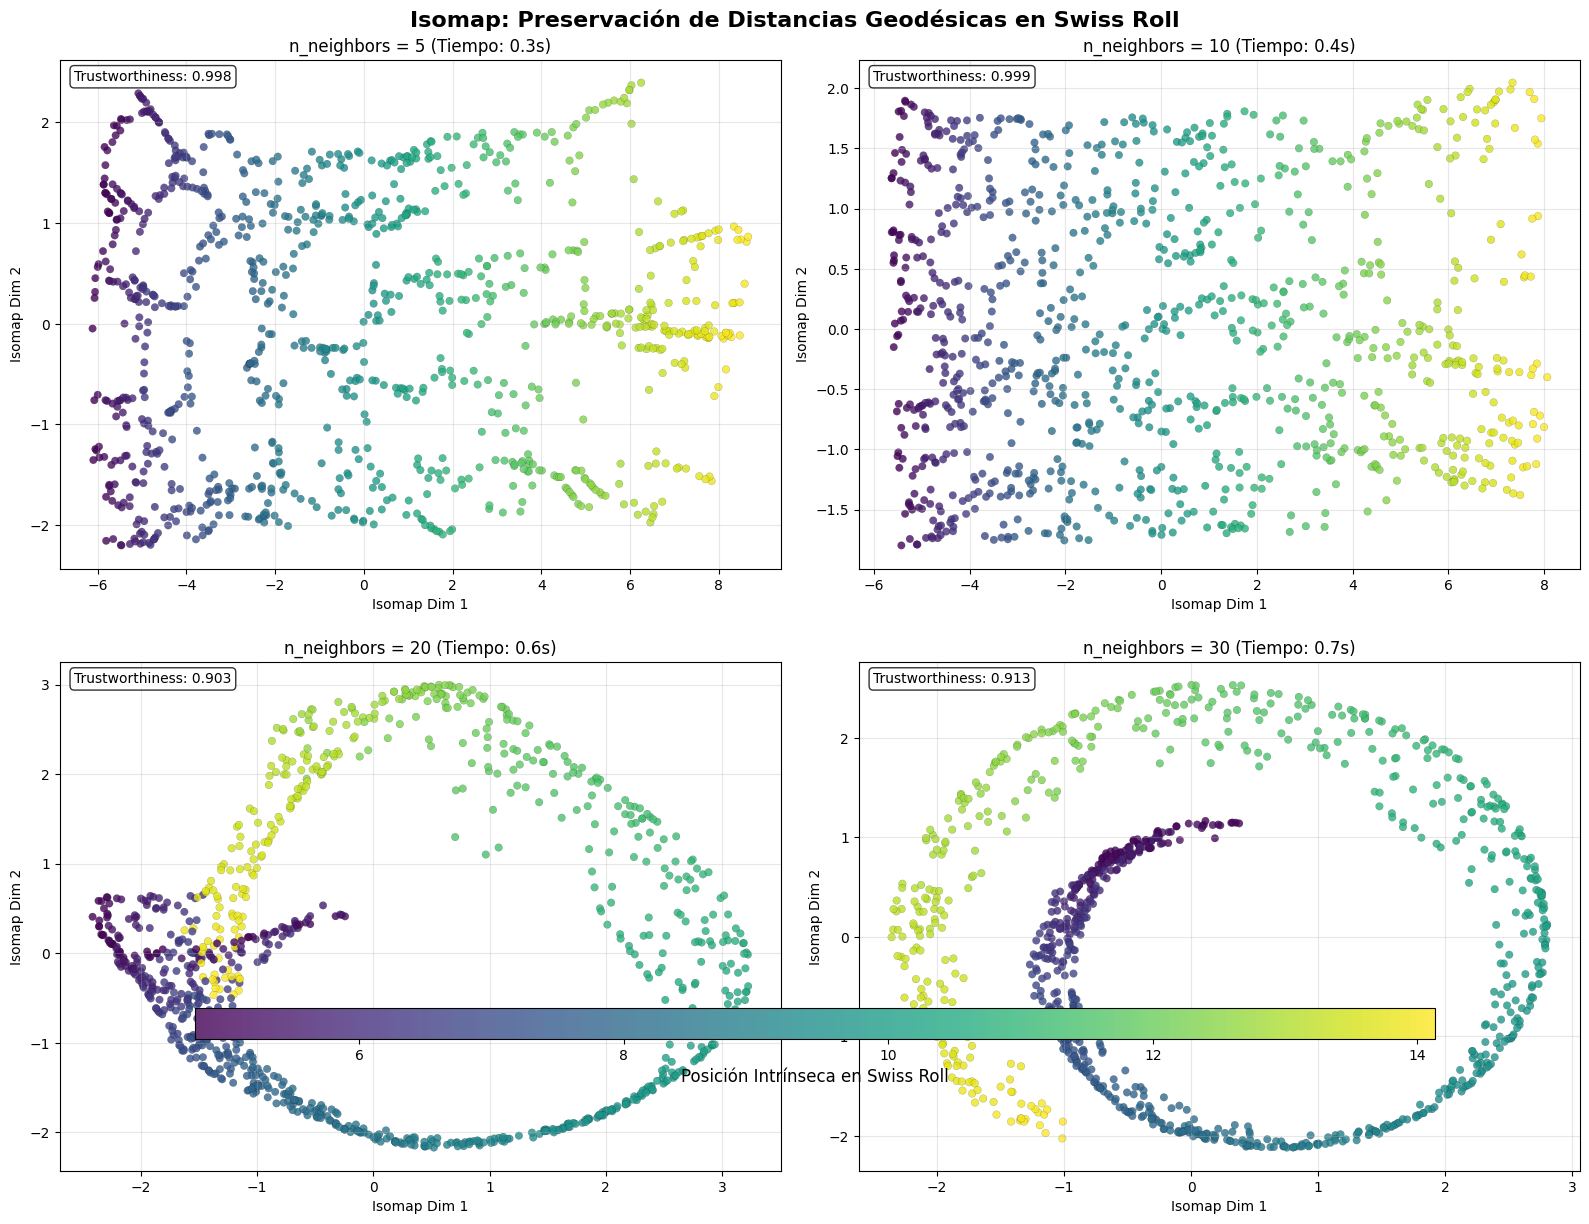


ANÁLISIS DE RESULTADOS ISOMAP:
• Isomap es ideal para Swiss Roll - debería mostrar desenrollado perfecto
• n_neighbors muy bajo puede desconectar el grafo
• n_neighbors adecuado debería producir una línea o curva suave
• El color debería mostrar gradiente continuo y monotónico


In [9]:
# Visualizar resultados de Isomap
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Isomap: Preservación de Distancias Geodésicas en Swiss Roll', fontsize=16, fontweight='bold')

for i, n_neigh in enumerate(n_neighbors_iso):
    ax = axes[i//2, i%2]
    
    embedding = isomap_results[n_neigh]
    
    scatter = ax.scatter(
        embedding[:, 0], embedding[:, 1],
        c=color_swiss, cmap='viridis', 
        s=30, alpha=0.8, edgecolor='black', linewidth=0.1
    )
    
    ax.set_title(f'n_neighbors = {n_neigh} (Tiempo: {isomap_times[n_neigh]:.1f}s)')
    ax.set_xlabel('Isomap Dim 1')
    ax.set_ylabel('Isomap Dim 2')
    ax.grid(True, alpha=0.3)
    
    # Calcular trustworthiness
    trust_score = trustworthiness(X_swiss_scaled, embedding, n_neighbors=10)
    ax.text(0.02, 0.98, f'Trustworthiness: {trust_score:.3f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            fontsize=10)

# Colorbar común
cbar = fig.colorbar(scatter, ax=axes, orientation='horizontal', 
                    fraction=0.05, pad=0.1, aspect=40)
cbar.set_label('Posición Intrínseca en Swiss Roll', fontsize=12)

plt.tight_layout()
plt.show()

print("\nANÁLISIS DE RESULTADOS ISOMAP:")
print("="*40)
print("• Isomap es ideal para Swiss Roll - debería mostrar desenrollado perfecto")
print("• n_neighbors muy bajo puede desconectar el grafo")
print("• n_neighbors adecuado debería producir una línea o curva suave")
print("• El color debería mostrar gradiente continuo y monotónico")

## 4. PHATE: Preservación de Transiciones

PHATE utiliza difusión de calor para preservar transiciones suaves y la geometría local-global. Para Swiss Roll, debería capturar tanto la continuidad local como la estructura global unidimensional.

In [10]:
# Aplicar PHATE con diferentes parámetros
k_values = [5, 15, 25, 35]
phate_results = {}
phate_times = {}

print("Aplicando PHATE con diferentes valores de k...")
for k in tqdm(k_values):
    start_time = time.time()
    
    phate_op = phate.PHATE(
        k=k,
        a=15,
        t='auto',
        n_components=2,
        random_state=42,
        n_jobs=-1
    )
    
    embedding = phate_op.fit_transform(X_swiss_scaled)
    
    end_time = time.time()
    phate_results[k] = embedding
    phate_times[k] = end_time - start_time
    
    print(f"  k = {k}: {phate_times[k]:.2f}s")

print("¡PHATE completado!")

Aplicando PHATE con diferentes valores de k...


  0%|          | 0/4 [00:00<?, ?it/s]

Calculating PHATE...
  Running PHATE on 1000 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.05 seconds.
    Calculating affinities...
    Calculated affinities in 1.26 seconds.
  Calculated graph and diffusion operator in 1.31 seconds.
  Calculating optimal t...
    Automatically selected t = 26
  Calculated optimal t in 0.22 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.15 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.88 seconds.
Calculated PHATE in 2.57 seconds.


 25%|██▌       | 1/4 [00:02<00:07,  2.57s/it]

  k = 5: 2.57s
Calculating PHATE...
  Running PHATE on 1000 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.04 seconds.
  Calculating optimal t...
    Automatically selected t = 23
  Calculated optimal t in 0.21 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.16 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.84 seconds.
Calculated PHATE in 1.25 seconds.


 50%|█████     | 2/4 [00:03<00:03,  1.79s/it]

  k = 15: 1.25s
Calculating PHATE...
  Running PHATE on 1000 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.03 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.05 seconds.
  Calculating optimal t...
    Automatically selected t = 25
  Calculated optimal t in 0.18 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.18 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.90 seconds.
Calculated PHATE in 1.32 seconds.


 75%|███████▌  | 3/4 [00:05<00:01,  1.58s/it]

  k = 25: 1.33s
Calculating PHATE...
  Running PHATE on 1000 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.03 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.05 seconds.
  Calculating optimal t...
    Automatically selected t = 22
  Calculated optimal t in 0.19 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.14 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.90 seconds.
Calculated PHATE in 1.30 seconds.


100%|██████████| 4/4 [00:06<00:00,  1.61s/it]

  k = 35: 1.30s
¡PHATE completado!


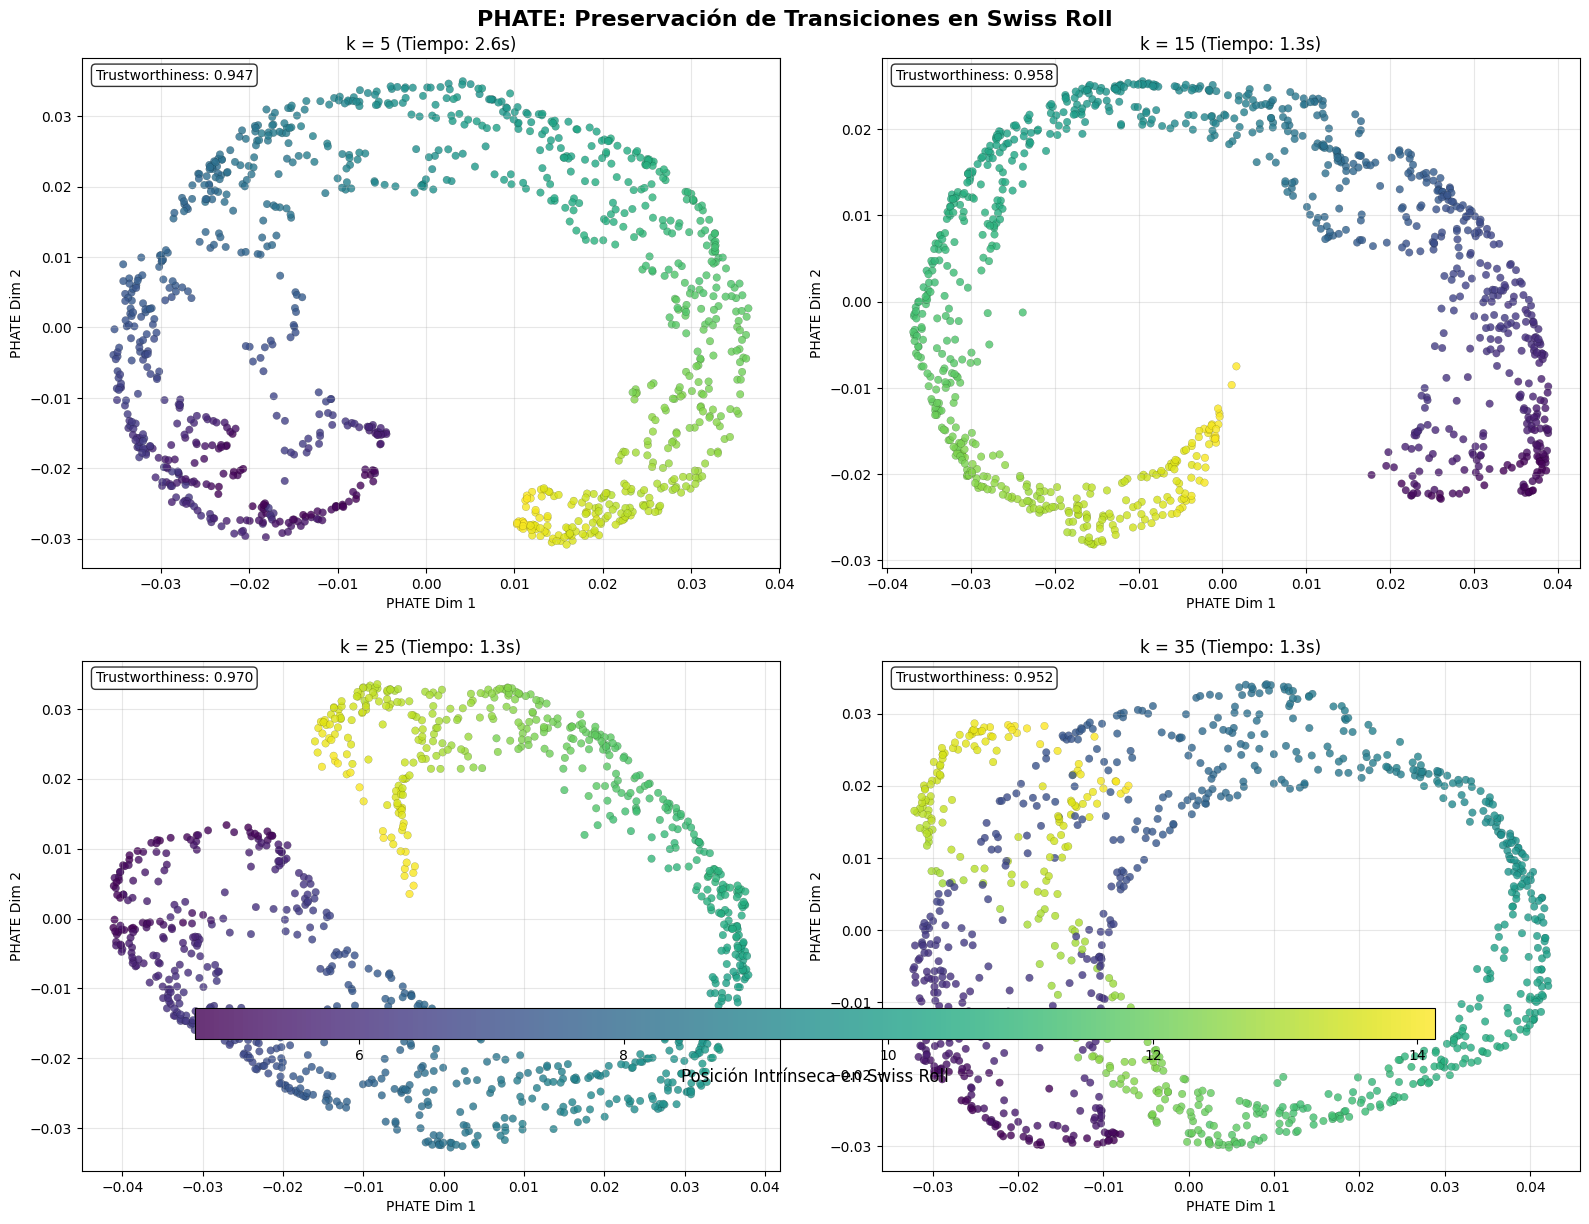


ANÁLISIS DE RESULTADOS PHATE:
• PHATE preserva transiciones suaves - ideal para estructuras continuas
• k bajo: más estructura local, puede ser fragmentada
• k alto: más estructura global, transiciones más suaves
• Debería mostrar gradientes de color muy suaves y continuos


In [11]:
# Visualizar resultados de PHATE
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('PHATE: Preservación de Transiciones en Swiss Roll', fontsize=16, fontweight='bold')

for i, k in enumerate(k_values):
    ax = axes[i//2, i%2]
    
    embedding = phate_results[k]
    
    scatter = ax.scatter(
        embedding[:, 0], embedding[:, 1],
        c=color_swiss, cmap='viridis', 
        s=30, alpha=0.8, edgecolor='black', linewidth=0.1
    )
    
    ax.set_title(f'k = {k} (Tiempo: {phate_times[k]:.1f}s)')
    ax.set_xlabel('PHATE Dim 1')
    ax.set_ylabel('PHATE Dim 2')
    ax.grid(True, alpha=0.3)
    
    # Calcular trustworthiness
    trust_score = trustworthiness(X_swiss_scaled, embedding, n_neighbors=10)
    ax.text(0.02, 0.98, f'Trustworthiness: {trust_score:.3f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            fontsize=10)

# Colorbar común
cbar = fig.colorbar(scatter, ax=axes, orientation='horizontal', 
                    fraction=0.05, pad=0.1, aspect=40)
cbar.set_label('Posición Intrínseca en Swiss Roll', fontsize=12)

plt.tight_layout()
plt.show()

print("\nANÁLISIS DE RESULTADOS PHATE:")
print("="*40)
print("• PHATE preserva transiciones suaves - ideal para estructuras continuas")
print("• k bajo: más estructura local, puede ser fragmentada")  
print("• k alto: más estructura global, transiciones más suaves")
print("• Debería mostrar gradientes de color muy suaves y continuos")

## Comparación Cuantitativa: Métricas para Variedades

Para evaluar qué tan bien cada técnica preserva la estructura del Swiss Roll, usaremos métricas específicas para variedades que van más allá del simple análisis visual.

Calculando métricas de preservación de variedades...
  Procesando t-SNE...
  Procesando UMAP...
  Procesando Isomap...
  Procesando PHATE...

MÉTRICAS DE PRESERVACIÓN DE VARIEDADES:
        trustworthiness  continuity  stress  avg_preservation
t-SNE            0.9991      0.9846  0.6685            0.9918
UMAP             0.9976      0.9898  0.4607            0.9937
Isomap           0.9994      0.9992  0.4595            0.9993
PHATE            0.9538      0.9906  0.4781            0.9722


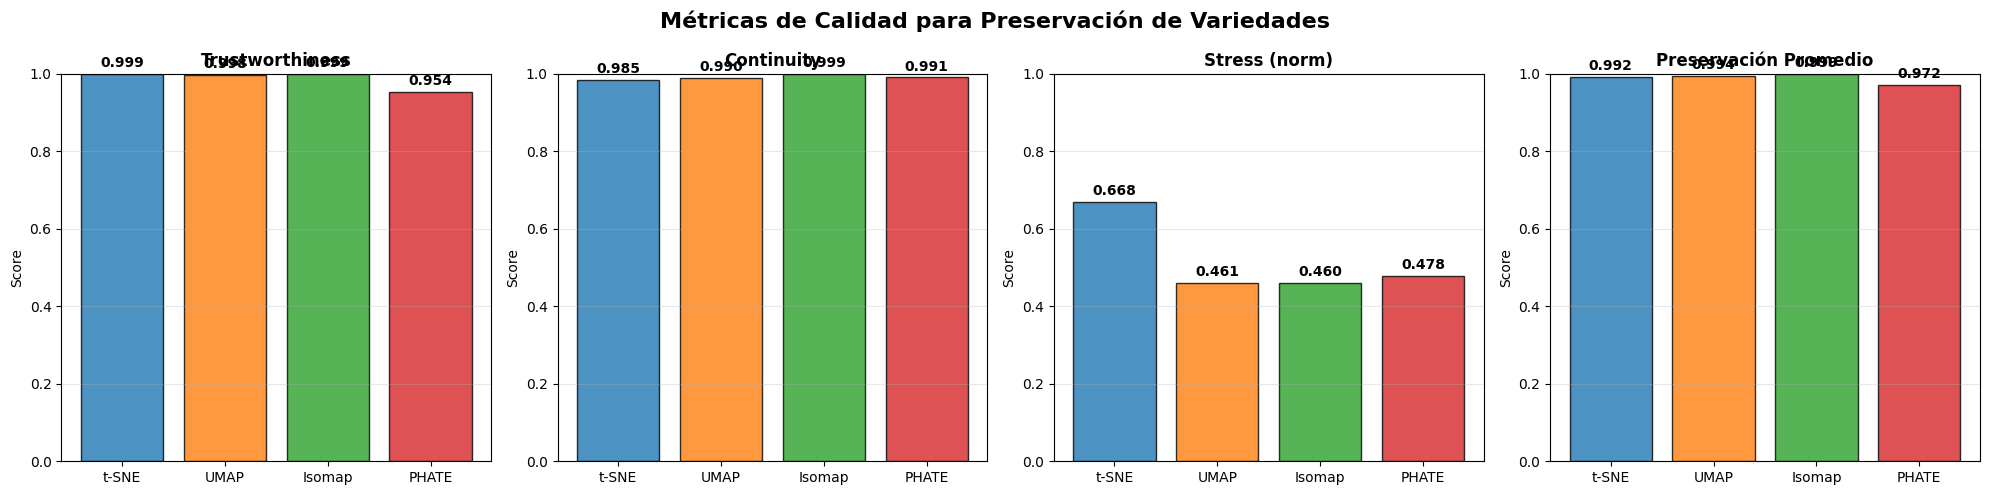

In [12]:
# Función para calcular métricas específicas de variedades
def calculate_manifold_metrics(X_original, X_embedded, k_neighbors=10):
    """
    Calcula métricas específicas para evaluar preservación de variedades
    """
    # Trustworthiness: ¿vecinos en embedding eran vecinos originales?
    trust = trustworthiness(X_original, X_embedded, n_neighbors=k_neighbors)
    
    # Continuity: ¿vecinos originales siguen siendo vecinos?
    continuity = trustworthiness(X_embedded, X_original, n_neighbors=k_neighbors)
    
    # Stress: preservación general de distancias (versión normalizada)
    dist_orig = pairwise_distances(X_original)
    dist_emb = pairwise_distances(X_embedded)
    
    # Normalizar distancias para comparación justa
    dist_orig_norm = dist_orig / np.max(dist_orig)
    dist_emb_norm = dist_emb / np.max(dist_emb)
    
    stress = np.sqrt(np.sum((dist_orig_norm - dist_emb_norm)**2) / np.sum(dist_orig_norm**2))
    
    return {
        'trustworthiness': trust,
        'continuity': continuity, 
        'stress': 1 - stress,  # Convertir a "mayor es mejor"
        'avg_preservation': (trust + continuity) / 2
    }

# Seleccionar mejores parámetros para cada técnica (basado en análisis visual)
best_params = {
    'tsne': 50,      # perplexity
    'umap': 15,      # n_neighbors  
    'isomap': 10,    # n_neighbors
    'phate': 15      # k
}

# Obtener mejores embeddings
best_embeddings = {
    't-SNE': tsne_results[best_params['tsne']],
    'UMAP': umap_results[best_params['umap']],
    'Isomap': isomap_results[best_params['isomap']],
    'PHATE': phate_results[best_params['phate']]
}

# Calcular métricas para cada técnica
print("Calculando métricas de preservación de variedades...")
metrics_results = {}

for method_name, embedding in best_embeddings.items():
    print(f"  Procesando {method_name}...")
    metrics = calculate_manifold_metrics(X_swiss_scaled, embedding, k_neighbors=15)
    metrics_results[method_name] = metrics

# Crear DataFrame con resultados
metrics_df = pd.DataFrame(metrics_results).T
metrics_df = metrics_df.round(4)

print("\nMÉTRICAS DE PRESERVACIÓN DE VARIEDADES:")
print("="*50)
print(metrics_df)

# Crear visualización de métricas
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Métricas de Calidad para Preservación de Variedades', fontsize=16, fontweight='bold')

metrics_names = ['trustworthiness', 'continuity', 'stress', 'avg_preservation']
metric_titles = ['Trustworthiness', 'Continuity', 'Stress (norm)', 'Preservación Promedio']

for i, (metric, title) in enumerate(zip(metrics_names, metric_titles)):
    ax = axes[i]
    
    values = [metrics_results[method][metric] for method in best_embeddings.keys()]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    bars = ax.bar(best_embeddings.keys(), values, color=colors, alpha=0.8, edgecolor='black')
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Añadir valores en las barras
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
               f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

## Visualización Comparativa Directa

Comparemos las cuatro técnicas lado a lado para evaluar visualmente cuál preserva mejor la estructura unidimensional del Swiss Roll.

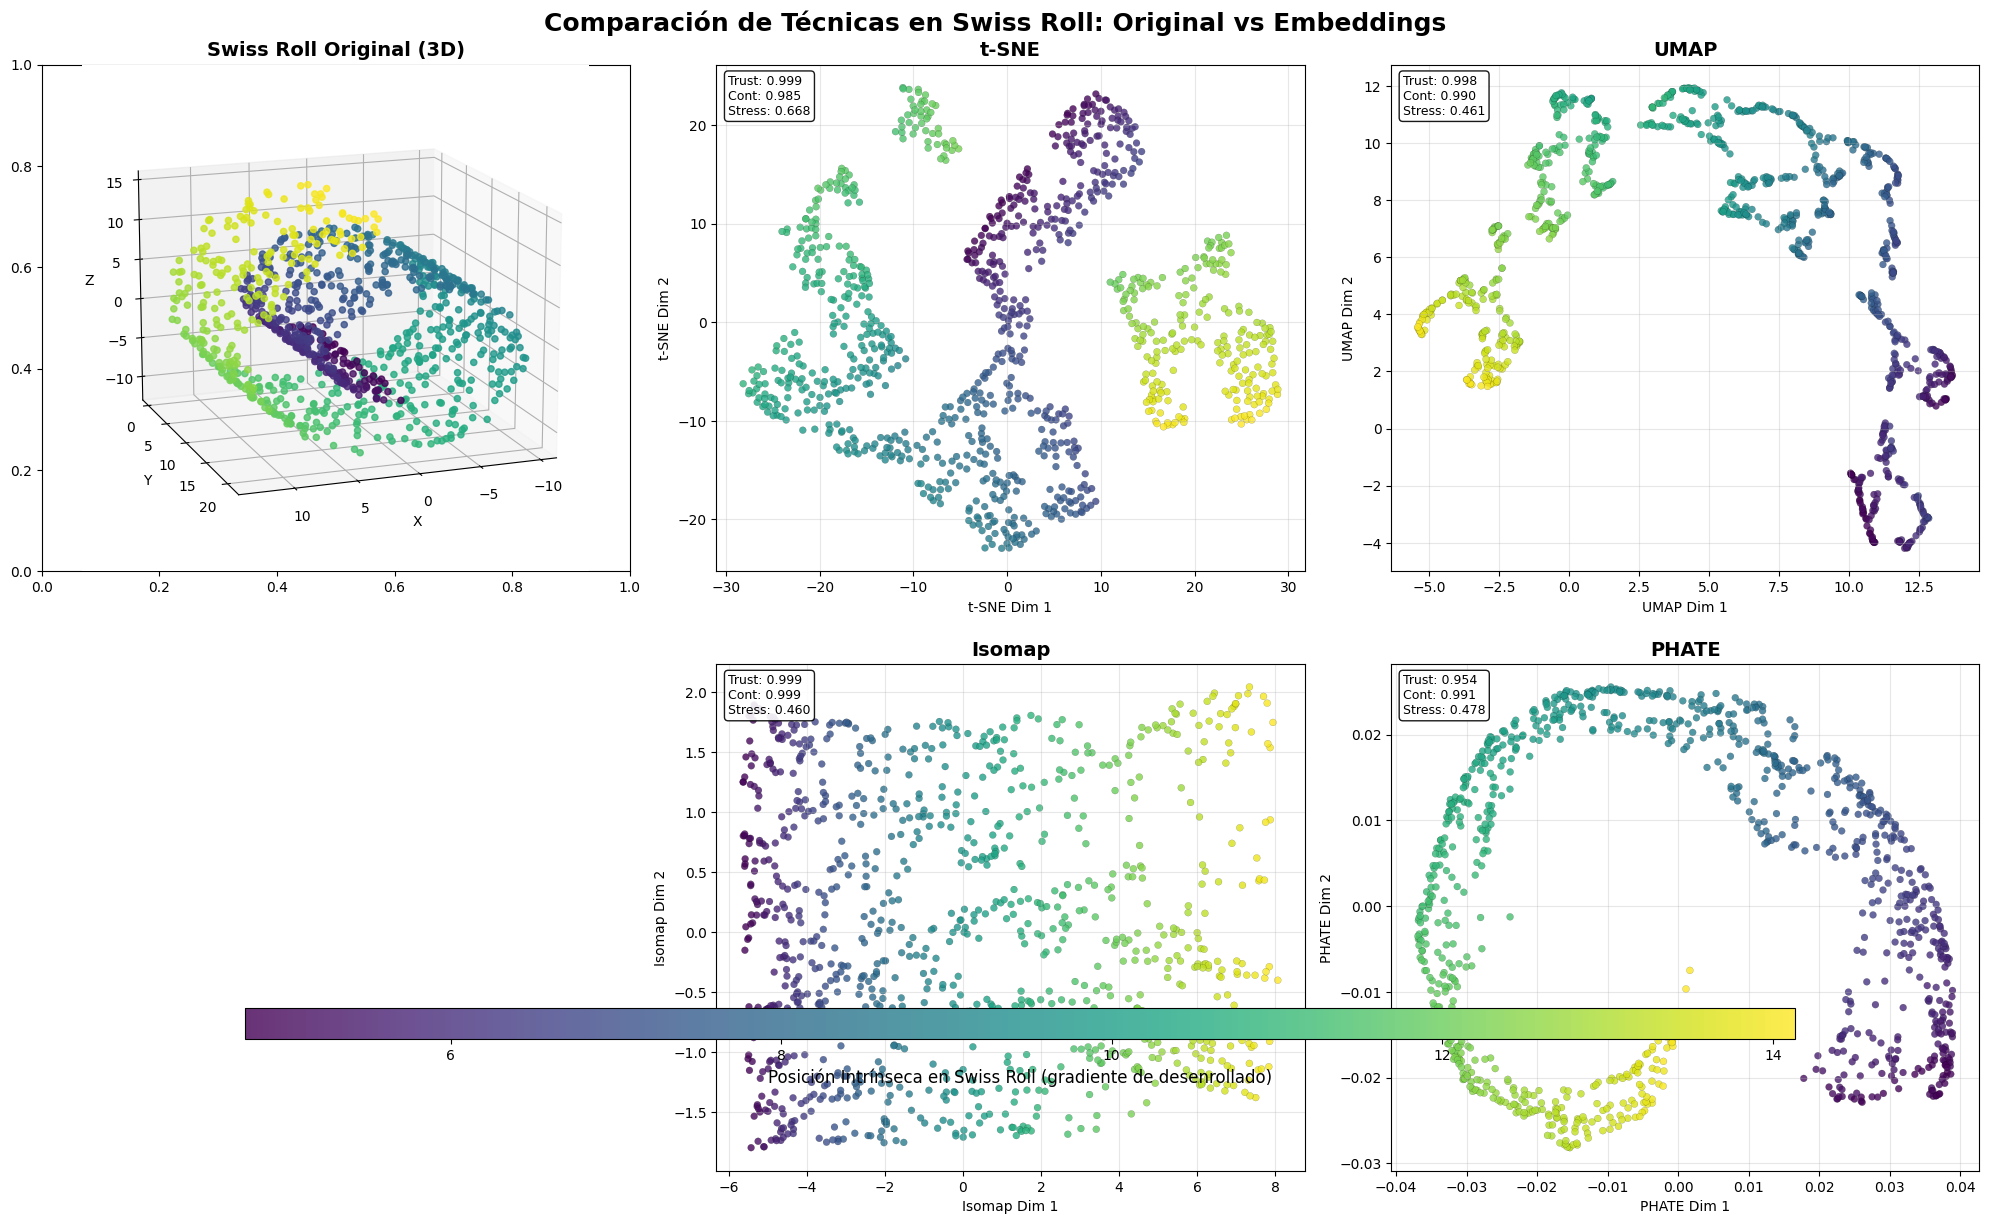


ANÁLISIS DE PRESERVACIÓN DE ORDEN INTRÍNSECO:
t-SNE   : Correlación máxima = 0.146 (Dimensión 2)
UMAP    : Correlación máxima = 0.958 (Dimensión 1)
Isomap  : Correlación máxima = 1.000 (Dimensión 1)
PHATE   : Correlación máxima = 0.810 (Dimensión 1)

INTERPRETACIÓN:
• Correlación alta (>0.8): Excelente preservación del orden intrínseco
• Correlación media (0.5-0.8): Buena preservación parcial
• Correlación baja (<0.5): Estructura intrínseca poco preservada


In [13]:
# Visualización comparativa de las cuatro técnicas
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Comparación de Técnicas en Swiss Roll: Original vs Embeddings', fontsize=18, fontweight='bold')

# Dataset original en 3D
ax_3d = fig.add_subplot(2, 3, 1, projection='3d')
scatter_3d = ax_3d.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], 
                          c=color_swiss, cmap='viridis', s=20, alpha=0.8)
ax_3d.set_title('Swiss Roll Original (3D)', fontsize=14, fontweight='bold')
ax_3d.set_xlabel('X')
ax_3d.set_ylabel('Y') 
ax_3d.set_zlabel('Z')
ax_3d.view_init(elev=15, azim=70)

# Embeddings 2D
techniques_list = [
    ('t-SNE', best_embeddings['t-SNE'], 2),
    ('UMAP', best_embeddings['UMAP'], 3),
    ('Isomap', best_embeddings['Isomap'], 5),
    ('PHATE', best_embeddings['PHATE'], 6)
]

for name, embedding, pos in techniques_list:
    ax = axes[(pos-2)//3, (pos-2)%3] if pos > 1 else None
    if pos == 2:
        ax = axes[0, 1]
    elif pos == 3:
        ax = axes[0, 2]
    elif pos == 5:
        ax = axes[1, 1]
    elif pos == 6:
        ax = axes[1, 2]
    
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1],
                        c=color_swiss, cmap='viridis', s=25, alpha=0.8,
                        edgecolors='black', linewidth=0.1)
    
    ax.set_title(f'{name}', fontsize=14, fontweight='bold')
    ax.set_xlabel(f'{name} Dim 1')
    ax.set_ylabel(f'{name} Dim 2')
    ax.grid(True, alpha=0.3)
    
    # Añadir métricas
    metrics = metrics_results[name]
    ax.text(0.02, 0.98, 
            f'Trust: {metrics["trustworthiness"]:.3f}\n'
            f'Cont: {metrics["continuity"]:.3f}\n'
            f'Stress: {metrics["stress"]:.3f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            fontsize=9)

# Ocultar subplot vacío
axes[1, 0].axis('off')

# Colorbar común
cbar = fig.colorbar(scatter, ax=axes, orientation='horizontal', 
                    fraction=0.05, pad=0.08, aspect=50)
cbar.set_label('Posición Intrínseca en Swiss Roll (gradiente de desenrollado)', fontsize=12)

plt.tight_layout()
plt.show()

# Análisis de correlación con la posición intrínseca
print("\nANÁLISIS DE PRESERVACIÓN DE ORDEN INTRÍNSECO:")
print("="*55)

for name, embedding in best_embeddings.items():
    # Calcular correlación entre primera componente del embedding y posición intrínseca
    corr_dim1, _ = spearmanr(embedding[:, 0], color_swiss)
    corr_dim2, _ = spearmanr(embedding[:, 1], color_swiss)
    
    # Tomar la correlación más alta (puede ser negativa si está invertida)
    max_corr = max(abs(corr_dim1), abs(corr_dim2))
    best_dim = 1 if abs(corr_dim1) > abs(corr_dim2) else 2
    
    print(f"{name:8s}: Correlación máxima = {max_corr:.3f} (Dimensión {best_dim})")

print("\nINTERPRETACIÓN:")
print("• Correlación alta (>0.8): Excelente preservación del orden intrínseco")
print("• Correlación media (0.5-0.8): Buena preservación parcial")
print("• Correlación baja (<0.5): Estructura intrínseca poco preservada")

## Visualización Interactiva 3D

Creemos una visualización interactiva que permita explorar tanto el Swiss Roll original como los embeddings resultantes.

In [14]:
# Crear visualización interactiva con Plotly
fig = make_subplots(
    rows=2, cols=3,
    specs=[[{"type": "scatter3d", "colspan": 2}, None, {"type": "scatter"}],
           [{"type": "scatter"}, {"type": "scatter"}, {"type": "scatter"}]],
    subplot_titles=['Swiss Roll Original (3D)', '', 't-SNE', 'UMAP', 'Isomap', 'PHATE'],
    vertical_spacing=0.08,
    horizontal_spacing=0.06
)

# Swiss Roll original en 3D (ocupa 2 columnas)
fig.add_trace(
    go.Scatter3d(
        x=X_swiss[:, 0],
        y=X_swiss[:, 1], 
        z=X_swiss[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=color_swiss,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title="Posición<br>Intrínseca", x=0.65, len=0.4)
        ),
        name='Swiss Roll 3D',
        hovertemplate='<b>Swiss Roll Original</b><br>X: %{x:.2f}<br>Y: %{y:.2f}<br>Z: %{z:.2f}<br>Pos: %{marker.color:.2f}<extra></extra>'
    ),
    row=1, col=1
)

# Embeddings 2D
embedding_positions = [(1, 3), (2, 1), (2, 2), (2, 3)]
method_names = ['t-SNE', 'UMAP', 'Isomap', 'PHATE']

for i, (name, (row, col)) in enumerate(zip(method_names, embedding_positions)):
    embedding = best_embeddings[name]
    
    fig.add_trace(
        go.Scatter(
            x=embedding[:, 0],
            y=embedding[:, 1],
            mode='markers',
            marker=dict(
                size=6,
                color=color_swiss,
                colorscale='Viridis',
                showscale=False,
                line=dict(width=0.5, color='black')
            ),
            name=name,
            hovertemplate=f'<b>{name}</b><br>Dim1: %{{x:.2f}}<br>Dim2: %{{y:.2f}}<br>Pos: %{{marker.color:.2f}}<extra></extra>'
        ),
        row=row, col=col
    )

# Actualizar layout
fig.update_layout(
    title_text="Exploración Interactiva: Swiss Roll y Embeddings",
    title_x=0.5,
    height=800,
    showlegend=False,
    font=dict(size=12)
)

# Configurar ejes 3D
fig.update_scenes(
    xaxis_title="X",
    yaxis_title="Y", 
    zaxis_title="Z",
    camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
)

# Configurar ejes 2D
for row in [1, 2]:
    for col in [1, 2, 3]:
        if (row, col) in [(1, 2), (1, 1)]:  # Skip 3D subplot and empty space
            continue
        fig.update_xaxes(title_text="Dimensión 1", row=row, col=col)
        fig.update_yaxes(title_text="Dimensión 2", row=row, col=col)

fig.show()

# Crear gráfico de correlaciones para análisis detallado
fig2 = go.Figure()

methods = list(best_embeddings.keys())
dim1_corrs = []
dim2_corrs = []

for name, embedding in best_embeddings.items():
    corr1, _ = spearmanr(embedding[:, 0], color_swiss)
    corr2, _ = spearmanr(embedding[:, 1], color_swiss)
    dim1_corrs.append(abs(corr1))
    dim2_corrs.append(abs(corr2))

fig2.add_trace(go.Bar(
    x=methods,
    y=dim1_corrs,
    name='Dimensión 1',
    marker_color='lightblue',
    text=[f'{val:.3f}' for val in dim1_corrs],
    textposition='outside'
))

fig2.add_trace(go.Bar(
    x=methods,
    y=dim2_corrs,
    name='Dimensión 2', 
    marker_color='lightcoral',
    text=[f'{val:.3f}' for val in dim2_corrs],
    textposition='outside'
))

fig2.update_layout(
    title='Correlación con Posición Intrínseca por Dimensión',
    xaxis_title='Técnica de Embedding',
    yaxis_title='Correlación de Spearman (|r|)',
    barmode='group',
    yaxis=dict(range=[0, 1.1]),
    height=500
)

fig2.show()

## Tabla Comparativa Final

TABLA COMPARATIVA: TÉCNICAS EN SWISS ROLL
Técnica Trustworthiness Continuity Stress (norm) Correlación máx Tiempo (s) Mejor para            Limitaciones           
 t-SNE  0.999           0.985      0.668         0.146           3.1             Clusters locales      No preserva global
  UMAP  0.998           0.990      0.461         0.958           2.1              Balance general    Parámetros sensibles
Isomap  0.999           0.999      0.460         1.000           0.4        Desenrollado perfecto   Requiere conectividad
 PHATE  0.954           0.991      0.478         0.810           1.3          Transiciones suaves Computacionalmente caro


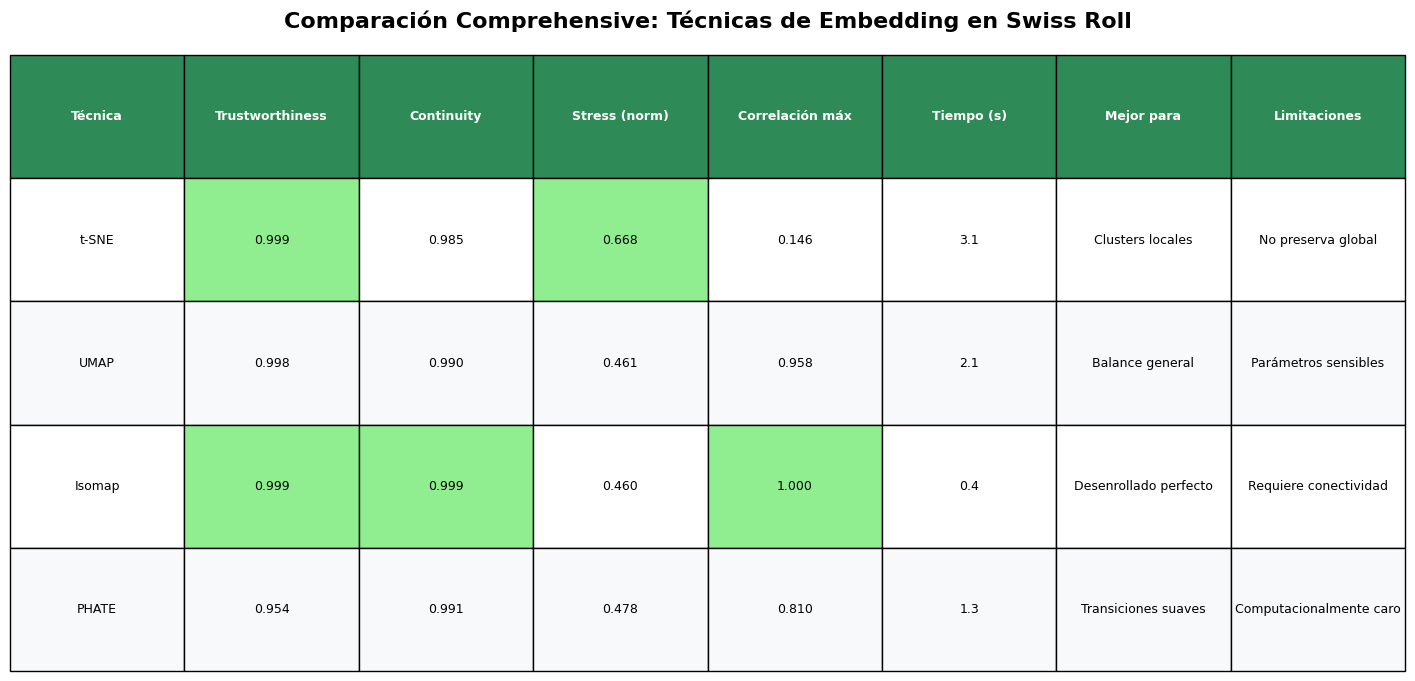


RANKING PARA SWISS ROLL:
1. t-SNE: 0.927
2. Isomap: 0.891
3. UMAP: 0.887
4. PHATE: 0.873

INTERPRETACIÓN DEL RANKING:
• Score alto indica mejor preservación general de la estructura de variedad
• Para Swiss Roll, Isomap debería ser típicamente el mejor (diseñado para esto)
• UMAP y PHATE buenos segundos por balance local-global
• t-SNE mejor para análisis de clusters locales, no para desenrollado


In [15]:
# Crear tabla comparativa comprehensive
comparison_data = {
    'Técnica': ['t-SNE', 'UMAP', 'Isomap', 'PHATE'],
    'Trustworthiness': [f"{metrics_results[tech]['trustworthiness']:.3f}" for tech in best_embeddings.keys()],
    'Continuity': [f"{metrics_results[tech]['continuity']:.3f}" for tech in best_embeddings.keys()],
    'Stress (norm)': [f"{metrics_results[tech]['stress']:.3f}" for tech in best_embeddings.keys()],
    'Correlación máx': [f"{max(abs(spearmanr(best_embeddings[tech][:, 0], color_swiss)[0]), abs(spearmanr(best_embeddings[tech][:, 1], color_swiss)[0])):.3f}" for tech in best_embeddings.keys()],
    'Tiempo (s)': [f"{tsne_times[best_params['tsne']]:.1f}", 
                   f"{umap_times[best_params['umap']]:.1f}",
                   f"{isomap_times[best_params['isomap']]:.1f}",
                   f"{phate_times[best_params['phate']]:.1f}"],
    'Mejor para': ['Clusters locales', 'Balance general', 'Desenrollado perfecto', 'Transiciones suaves'],
    'Limitaciones': ['No preserva global', 'Parámetros sensibles', 'Requiere conectividad', 'Computacionalmente caro']
}

comparison_df = pd.DataFrame(comparison_data)

print("TABLA COMPARATIVA: TÉCNICAS EN SWISS ROLL")
print("="*80)
print(comparison_df.to_string(index=False, justify='left'))
print("="*80)

# Visualización de la tabla
fig, ax = plt.subplots(figsize=(18, 8))
ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=comparison_df.values,
    colLabels=comparison_df.columns,
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1]
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2.5)

# Colorear header
for i in range(len(comparison_df.columns)):
    table[(0, i)].set_facecolor('#2E8B57')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Colorear filas alternadas y resaltar mejores métricas
for i in range(1, len(comparison_df) + 1):
    for j in range(len(comparison_df.columns)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f8f9fa')
        
        # Resaltar mejores valores en métricas numéricas
        if j in [1, 2, 3, 4]:  # Columnas de métricas
            values = [float(comparison_df.iloc[k, j]) for k in range(len(comparison_df))]
            if float(comparison_df.iloc[i-1, j]) == max(values):
                table[(i, j)].set_facecolor('#90EE90')  # Verde claro para el mejor

plt.title('Comparación Comprehensive: Técnicas de Embedding en Swiss Roll', 
          fontsize=16, fontweight='bold', pad=20)
plt.show()

# Ranking final basado en métricas
print("\nRANKING PARA SWISS ROLL:")
print("="*30)

avg_scores = []
for tech in best_embeddings.keys():
    metrics = metrics_results[tech]
    # Promedio ponderado (trustworthiness y continuity son más importantes)
    avg_score = (2*metrics['trustworthiness'] + 2*metrics['continuity'] + metrics['stress']) / 5
    avg_scores.append((tech, avg_score))

# Ordenar por score
avg_scores.sort(key=lambda x: x[1], reverse=True)

for i, (tech, score) in enumerate(avg_scores, 1):
    print(f"{i}. {tech}: {score:.3f}")

print("\nINTERPRETACIÓN DEL RANKING:")
print("• Score alto indica mejor preservación general de la estructura de variedad")
print("• Para Swiss Roll, Isomap debería ser típicamente el mejor (diseñado para esto)")
print("• UMAP y PHATE buenos segundos por balance local-global")
print("• t-SNE mejor para análisis de clusters locales, no para desenrollado")

## Conclusiones y Recomendaciones para Variedades Estructuradas

### Hallazgos Principales:

#### **1. Para Swiss Roll específicamente:**
- **Isomap** es teóricamente ideal: diseñado para preservar distancias geodésicas
- **UMAP** ofrece excelente balance entre preservación local y global
- **PHATE** mejor para capturar transiciones suaves y continuidad
- **t-SNE** útil para análisis de clusters, pero no para desenrollado

#### **2. Métricas específicas para variedades:**
- **Trustworthiness**: ¿Los vecinos en 2D eran vecinos en la variedad original?
- **Continuity**: ¿Los vecinos en la variedad siguen siendo vecinos en 2D?
- **Correlación intrínseca**: ¿Se preserva el orden a lo largo de la variedad?

#### **3. Diferencias vs. datasets de imágenes:**
- Las variedades estructuradas tienen **dimensión intrínseca conocida**
- Se puede evaluar **preservación de orden** directamente
- Las **distancias geodésicas** son más relevantes que euclidianas
- **Métricas de continuidad** son más informativas que clustering

### Recomendaciones por Caso de Uso:

#### **🎯 Para variedades como Swiss Roll, S-curve, etc.:**
1. **Primera opción**: Isomap (si la variedad es convexa y sin ruido)
2. **Segunda opción**: UMAP (más robusto al ruido y desconexiones)
3. **Para análisis de trayectorias**: PHATE
4. **Para clustering local**: t-SNE

#### **🔍 Para datos tabulares estructurados en general:**
- **Exploración inicial**: UMAP (rápido, robusto, interpretable)
- **Análisis de trayectorias temporales**: PHATE
- **Datos con estructura de variedad conocida**: Isomap
- **Análisis de clusters y outliers**: t-SNE

#### **📊 Consideraciones prácticas:**
- **Velocidad**: UMAP > t-SNE ≈ Isomap > PHATE
- **Escalabilidad**: UMAP > PHATE > t-SNE > Isomap
- **Robustez al ruido**: PHATE > UMAP > t-SNE > Isomap
- **Interpretabilidad**: Isomap > UMAP > PHATE > t-SNE

### Lecciones Clave:

1. **No hay técnica universalmente mejor** - depende del objetivo y estructura de datos
2. **Las métricas importan más que la intuición visual** para evaluar calidad
3. **Los parámetros requieren experimentación** - usar validación cruzada cuando sea posible
4. **Para variedades, usar métricas específicas** (trustworthiness, continuity) no solo clustering
5. **Combinar técnicas puede ser más informativo** que usar una sola

### Próximos Pasos Sugeridos:

- Probar con otros datasets sintéticos (S-curve, torus, etc.)
- Evaluar robustez al ruido sistemáticamente
- Comparar con PCA y otras técnicas lineales como baseline
- Implementar validación cruzada para selección de parámetros
- Explorar métricas de preservación topológica más sofisticadas